# Importing and Plotting NASS Maize Yield Data

Load in required packages:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader
import shapely.affinity as shp
import datetime
#import statsmodels.api as sm
%matplotlib inline

In [2]:
# Reading in state & county id
state_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/stateID.txt", sep="\s+", header=None)
state_id = state_id.transpose()
state_id.columns = ["state_id"]
county_id = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/countyID.txt", sep="\s+", header=None)
county_id = county_id.transpose()
county_id.columns = ["county_id"]

In [3]:
# Reading in lat & lon information
lat_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lat_county.txt", sep="\s+", header=None)
lat_county = lat_county.transpose()
lat_county.columns = ["lat"]
lon_county = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/lon_county.txt", sep="\s+", header=None)
lon_county = lon_county.transpose()
lon_county.columns = ["lon"]

In [4]:
# Reading in maize yield
cornyield = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_yield.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornyield.columns = years
cornyield.head()

,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.465054,4.142656,2.510701,NaN,NaN,NaN,6.973471,NaN,6.276752,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.783172,5.586309,6.590589,NaN,7.783172,10.162061,4.136379,7.739235,9.841947,8.718408
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.155497,4.707564,6.465054,NaN,6.841659,4.983741,7.506995,NaN,9.678751,10.438238
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.904427,NaN,6.873043,4.393726,8.655641,9.038522


In [5]:
# Reading in maize area
cornarea = pd.read_csv("/home/disk/eos8/ach315/data/NASS_cropdata/corn_area.txt", sep="\s+", header=None)
years = np.arange(1910, 2015)
cornarea.columns = years
cornarea = cornarea.melt(var_name='year', value_name='area')
cornarea = cornarea.drop(['year'], axis=1)
cornarea.head()

,area
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [6]:
# concatinating all information and melting dataframe
df = pd.concat([state_id, county_id, lat_county, lon_county, cornyield], axis=1)
df = pd.melt(df, id_vars=['state_id', 'county_id', 'lat', 'lon'], value_name='yield', var_name="year")
df = pd.concat([df, cornarea], axis=1)
print(df.shape)
df.head()

(326340, 7)


,state_id,county_id,lat,lon,year,yield,area
0,1.0,1.0,32.462991,-86.709691,1910,NaN,NaN
1,1.0,3.0,30.787262,-87.712913,1910,NaN,NaN
2,1.0,5.0,31.870087,-85.383129,1910,NaN,NaN
3,1.0,7.0,33.072877,-87.112698,1910,NaN,NaN
4,1.0,9.0,33.988350,-86.613622,1910,NaN,NaN


In [7]:
# subsetting data for year 1961-1990
df_subset = pd.DataFrame()
years = np.arange(1961,1991)

for i in range(len(years)):
    data = df[df['year'] == years[i]]
    df_subset = pd.concat([df_subset, data])

print(df_subset.shape)
df_subset.head()

(93240, 7)


,state_id,county_id,lat,lon,year,yield,area
158508,1.0,1.0,32.462991,-86.709691,1961,2.008560,6758.2607
158509,1.0,3.0,30.787262,-87.712913,1961,2.761771,9024.5038
158510,1.0,5.0,31.870087,-85.383129,1961,1.945793,11452.6210
158511,1.0,7.0,33.072877,-87.112698,1961,2.259631,2092.2280
158512,1.0,9.0,33.988350,-86.613622,1961,2.322398,10064.5470


In [9]:
# calculating mean yield & area planted across 1961-1990
df_sitemean = df_subset.groupby(['state_id', 'county_id']).mean()
df_sitemean = df_sitemean.reset_index()
df_sitemean.head()

,state_id,county_id,lat,lon,yield,area
0,1.0,1.0,32.462991,-86.709691,2.462788,2956.233183
1,1.0,3.0,30.787262,-87.712913,4.256056,9584.319770
2,1.0,5.0,31.870087,-85.383129,2.689588,5805.224477
3,1.0,7.0,33.072877,-87.112698,2.303269,913.049299
4,1.0,9.0,33.988350,-86.613622,3.113897,3230.340665


## Building Simple Linear Yield Model

In [10]:
df_weasum = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', index_col=0)
df_weasum.head()

,sites,year,temp,rh,precip,lat,lon
0,3103,1964,14.280639,0.485070,2207.0,35.08,111.4
1,3103,1966,14.703397,0.521153,843.0,35.08,111.4
2,3103,1967,13.812092,0.538665,1164.0,35.08,111.4
3,3103,1969,13.825272,0.469296,510.0,35.08,111.4
4,3103,1970,14.284375,0.467291,885.0,35.08,111.4


In [11]:
df_weasorted = df_weasum.groupby(['year', 'sites']).mean()
df_weasorted.head()

temp        rh  precip    lat    lon
year sites                                           
1961 3813   23.239380  0.699114  4640.0  32.42  83.39
     3820   22.680978  0.740047  4285.0  33.22  81.58
     3822   23.503736  0.766811  6844.0  32.08  81.12
     3856   21.821513  0.702747  4758.0  34.39  86.46
     3928   20.971467  0.681485  6898.0  37.39  97.25

In [12]:
df_subset = df_subset.reset_index()
df_sitesorted = df_subset.groupby(['year','state_id', 'county_id']).mean()
df_sitesorted.head()

index        lat        lon     yield        area
year state_id county_id                                                    
1961 1.0      1.0        158508  32.462991 -86.709691  2.008560   6758.2607
              3.0        158509  30.787262 -87.712913  2.761771   9024.5038
              5.0        158510  31.870087 -85.383129  1.945793  11452.6210
              7.0        158511  33.072877 -87.112698  2.259631   2092.2280
              9.0        158512  33.988350 -86.613622  2.322398  10064.5470

In [14]:
years = np.arange(1961,1991)
temp_all = []
precip_all = []

for i in range(len(years)):
    myield = df_sitesorted.loc[years[i], :]
    wea = df_weasorted.loc[years[i], :]
    wea = wea.reset_index()
    lat = list(myield.lat)
    lon = list(abs(myield.lon))
    print(years[i])
    
    temp = []
    precip = []
    
    for j in range(len(lat)):
        lat_dis = abs(wea.lat - lat[j])
        lon_dis = abs(wea.lon - lon[j])
        total_dis = list(lat_dis + lon_dis)
        index = total_dis.index(min(total_dis))
        temp.append(wea.temp[index])
        precip.append(wea.precip[index])
    
    temp_all.extend(temp)
    precip_all.extend(precip)

1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990


In [16]:
df_sitesorted['temp'] = temp_all
df_sitesorted['precip'] = precip_all
df_sitesorted.head()

index        lat        lon     yield        area  \
year state_id county_id                                                       
1961 1.0      1.0        158508  32.462991 -86.709691  2.008560   6758.2607   
              3.0        158509  30.787262 -87.712913  2.761771   9024.5038   
              5.0        158510  31.870087 -85.383129  1.945793  11452.6210   
              7.0        158511  33.072877 -87.112698  2.259631   2092.2280   
              9.0        158512  33.988350 -86.613622  2.322398  10064.5470   

                              temp  precip  
year state_id county_id                     
1961 1.0      1.0        22.867385  5041.0  
              3.0        23.637409  9241.0  
              5.0        22.867385  5041.0  
              7.0        22.433197  6498.0  
              9.0        21.821513  4758.0

In [17]:
df_reset = df_sitesorted.groupby(['state_id', 'county_id', 'year']).mean()
df_reset = df_reset.reset_index()
df_reset.head()

,state_id,county_id,year,index,lat,lon,yield,area,temp,precip
0,1.0,1.0,1961,158508,32.462991,-86.709691,2.008560,6758.2607,22.867385,5041.0
1,1.0,1.0,1962,161616,32.462991,-86.709691,1.569188,6252.4028,25.176886,4711.0
2,1.0,1.0,1963,164724,32.462991,-86.709691,2.259631,6474.9803,24.474524,4552.0
3,1.0,1.0,1964,167832,32.462991,-86.709691,2.071328,6515.4489,22.413296,6138.0
4,1.0,1.0,1965,170940,32.462991,-86.709691,2.761771,4370.6117,22.823641,1554.0


In [70]:
state_id = list(set(df_reset.state_id))
county_id = list(set(df_reset.county_id))

latitude = []
longitude = []
rsquare_t = []
rsquare_p = []
par_temperature = []
par_precipitation = []

for i in state_id:
    for j in county_id:
        df_subset = df_reset.loc[(df_reset.state_id==i) & (df_reset.county_id==j), :]
        df_subset = df_subset.dropna()
        lat = df_subset.lat.mean()
        lon = df_subset.lon.mean()
        latitude.append(lat)
        longitude.append(lon)
        
        try:
            temp = df_subset['temp']
            y = df_subset['yield']
            model_t = sm.OLS(y, temp).fit()
            r2_t = model_t.rsquared
            par_temp = model_t.params[0]
            rsquare_t.append(r2_t)
            par_temperature.append(par_temp)
            
        except:
            rsquare_t.append(np.nan)
            par_temperature.append(np.nan)
        
        try:
            precip = df_subset['precip']
            y = df_subset['yield']
            model_p = sm.OLS(y, precip).fit()
            r2_p = model_p.rsquared
            par_precip = model_p.params[0]
            rsquare_p.append(r2_p)
            par_precipitation.append(par_precip)
            
        except:
            rsquare_p.append(np.nan)
            par_precipitation.append(np.nan)



/home/disk/eos8/ach315/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/disk/eos8/ach315/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [74]:
df_mod = pd.DataFrame({'lat': latitude,
                       'lon': longitude,
                       'r2_temp': rsquare_t,
                       'r2_precip': rsquare_p,
                       'par_temp': par_temperature,
                       'par_precip': par_precipitation})
df_mod = df_mod.dropna()
df_mod = df_mod[df_mod['par_precip'] < 0.06]

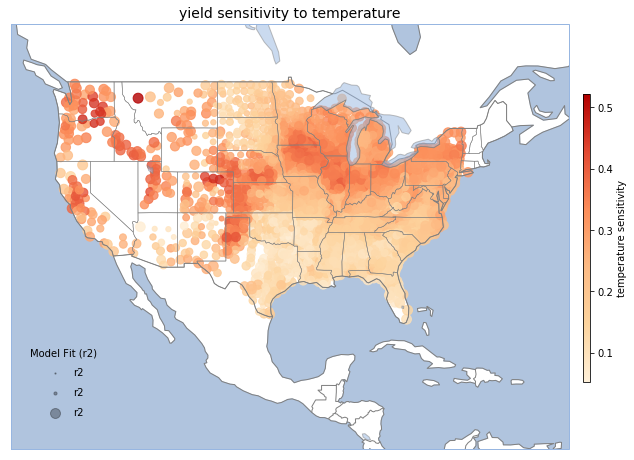

In [186]:
from palettable.colorbrewer.sequential import OrRd_6
water = (0.59375 , 0.71484375, 0.8828125)
rsquare_tscale = [pow(100,i) for i in df_mod['r2_temp']]

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
ax1.set_extent([-130, -60, 10, 48])
ax1.scatter(df_mod['lon'], df_mod['lat'], transform=ccrs.PlateCarree(), 
            c=df_mod['par_temp'], s=rsquare_tscale, 
            cmap=OrRd_6.mpl_colormap, alpha=0.8)

ax1.add_feature(cfeature.OCEAN, color='lightsteelblue')
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.LAKES, edgecolor='grey', facecolor=water, alpha=0.5)
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.outline_patch.set_edgecolor(water)
ax1.set_title('yield sensitivity to temperature', fontsize=14)


lim = np.array([[df_mod['par_temp'].min(), df_mod['par_temp'].max()]])
im1 = plt.imshow(lim, cmap=OrRd_6.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('temperature sensitivity')

for r2 in [pow(100, 0.1), pow(100, 0.5), pow(100, 1)]:
    plt.scatter([], [], c='k', alpha=0.3, s=r2,
                label= 'r2')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Model Fit (r2)', 
           loc=2, bbox_to_anchor=(-78,0.15))

plt.savefig('sensitivity_temp.eps', format='eps', dpi=1000)

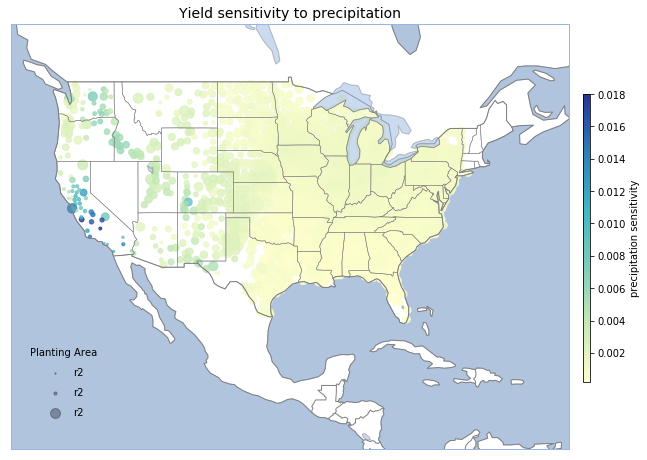

In [189]:
from palettable.colorbrewer.sequential import YlGnBu_6
water = (0.59375 , 0.71484375, 0.8828125)
rsquare_pscale = [pow(100,i) for i in df_mod['r2_precip']]

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
ax1.set_extent([-130, -60, 10, 48])
ax1.scatter(df_mod['lon'], df_mod['lat'], transform=ccrs.PlateCarree(), 
            c=df_mod['par_precip'], s=rsquare_pscale, 
            cmap=YlGnBu_6.mpl_colormap, alpha=0.8)

ax1.add_feature(cfeature.OCEAN, color='lightsteelblue')
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.LAKES, edgecolor='grey', facecolor=water, alpha=0.5)
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.outline_patch.set_edgecolor(water)
ax1.set_title('Yield sensitivity to precipitation', fontsize=14)


lim = np.array([[df_mod['par_precip'].min(), df_mod['par_precip'].max()]])
im1 = plt.imshow(lim, cmap=YlGnBu_6.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('precipitation sensitivity')

for area in [pow(100,0.1), pow(100,0.5), pow(100,1)]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label='r2')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Planting Area', 
           loc=2, bbox_to_anchor=(-78,0.15))

plt.savefig('sensitivity_precip.eps', format='eps', dpi=1000)

## Visualizing Yield Data

In [ ]:
# yield = bu/acre
# need to convert into tons/ha
# unit conversions for yield claculation
lbperbu = 56
kgperlb = 0.453592
acreperha = 2.47105

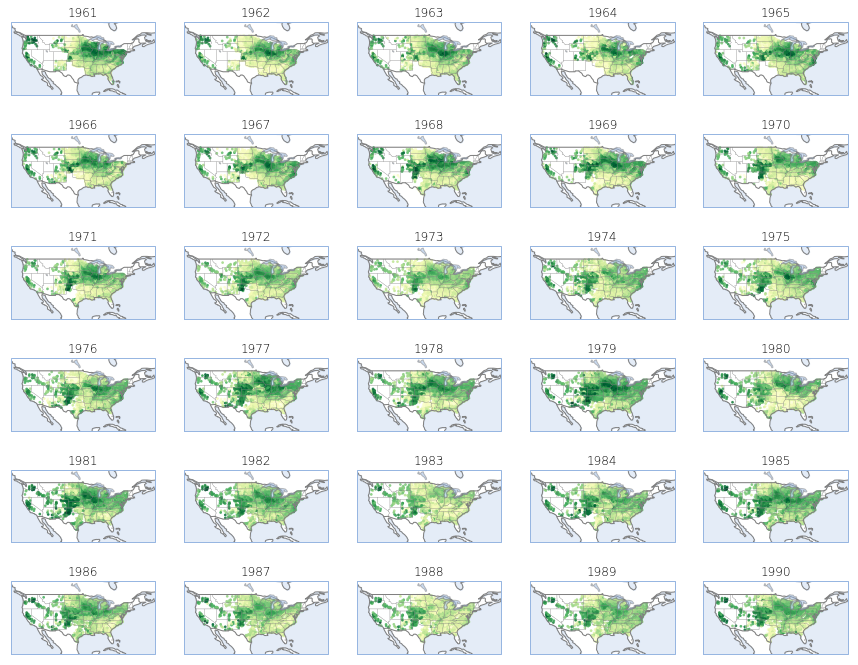

In [232]:
years = np.arange(1961,1991)
fig = plt.figure(figsize=(15,12))

for i in range(len(years)):
    data = df[df['year'] == years[i]]
    ax = fig.add_subplot(6,5,i+1, projection=ccrs.PlateCarree())
    ax.set_extent([-130, -60, 20, 50])
    ax.scatter(data['lon'], data['lat'], transform=ccrs.PlateCarree(),
               c=data['yield']*lbperbu*kgperlb/1000, s=3, cmap=YlGn_9.mpl_colormap, alpha=0.8)
    ax.add_feature(cfeature.OCEAN, color=water, alpha=0.25)
    ax.add_feature(cfeature.BORDERS, edgecolor="grey")
    ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
    ax.add_feature(cfeature.LAKES, edgecolor="grey", facecolor=water, alpha=0.5)
    ax.add_feature(cfeature.STATES, edgecolor="grey", linewidth=0.2)
    ax.outline_patch.set_edgecolor(water)
    ax.set_title(years[i], fontsize=12, fontweight=2)



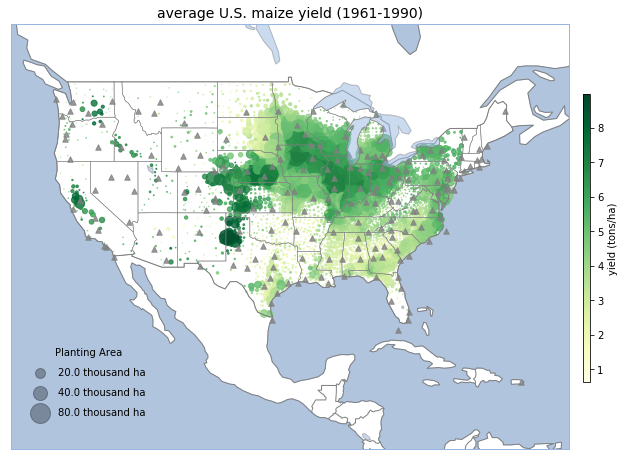

In [182]:
from palettable.colorbrewer.sequential import YlGn_9
#water = (0.59375 , 0.71484375, 0.8828125)

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
ax1.set_extent([-130, -60, 10, 48])
ax1.scatter(df_sitemean['lon'], df_sitemean['lat'], transform=ccrs.PlateCarree(), 
            c=df_sitemean['yield']*lbperbu*kgperlb/1000, s=df_sitemean['area']/200, 
            cmap=YlGn_9.mpl_colormap, alpha=0.8)
ax1.scatter(360-df_wea['lon'], df_wea['lat'], transform=ccrs.PlateCarree(), 
            c='grey', marker='^', s=30, alpha=0.8)


ax1.add_feature(cfeature.OCEAN, color='lightsteelblue')
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.LAKES, edgecolor='grey', facecolor=water, alpha=0.5)
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax1.outline_patch.set_edgecolor(water)
ax1.set_title('average U.S. maize yield (1961-1990)', fontsize=14)


yield_lim = np.array([[df_sitemean['yield'].min(), df_sitemean['yield'].max()]])
im1 = plt.imshow(yield_lim, cmap=YlGn_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('yield (tons/ha)')

for area in [100, 200, 400]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area*200/1000) + ' thousand ha')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Planting Area', 
           facecolor='red', loc=2, bbox_to_anchor=(-78,0.15))

plt.savefig('myield_6190.eps', format='eps', dpi=1000)

## Visualizing Weather Data

In [169]:
# Reading in weather data
df_wea = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/weadata_sitemean.csv')

Text(0,0.5,'mm')

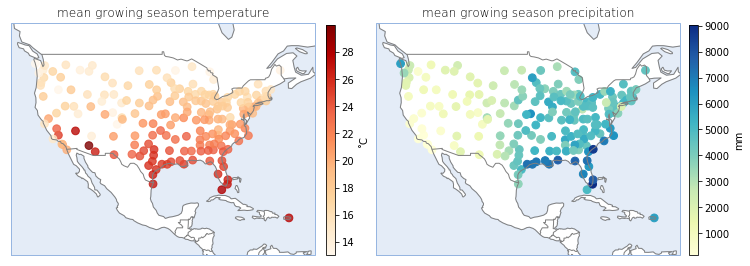

In [469]:
# visualizing weather data
temp_max = df_wea["temp"].max()
temp_min = df_wea["temp"].min()
precip_max = df_wea["precip"].max()
precip_min = df_wea["precip"].min()

# setting up figure 
fig = plt.figure(figsize=(12,8))

# plotting temperature
ax1 = fig.add_subplot(1,2,1, projection=ccrs.Mercator())
ax1.set_extent([-130, -60, 10, 48])
ax1.scatter(360-df_wea['lon'], df_wea['lat'], transform=ccrs.PlateCarree(), 
            c=df_wea['temp'], s=60, cmap=OrRd_9.mpl_colormap, alpha=0.8)

ax1.add_feature(cfeature.OCEAN, color=water, alpha=0.25)
ax1.add_feature(cfeature.BORDERS, edgecolor="grey")
ax1.add_feature(cfeature.COASTLINE, edgecolor="grey")
ax1.outline_patch.set_edgecolor(water)
ax1.set_title("mean growing season temperature", fontsize=12, fontweight=2)

temp_lim = np.array([[temp_min, temp_max]])
im1 = plt.imshow(temp_lim, cmap=OrRd_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.49, 0.3, 0.01, 0.4]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('˚C')

# plotting precipitation
ax2 = fig.add_subplot(1,2,2, projection=ccrs.Mercator())
ax2.set_extent([-130, -60, 10, 48])
ax2.scatter(360-df_wea['lon'], df_wea['lat'], transform=ccrs.PlateCarree(), 
            c=df_wea['precip'], s=60, cmap=YlGnBu_8.mpl_colormap, alpha=1)

ax2.add_feature(cfeature.OCEAN, color=water, alpha=0.25)
ax2.add_feature(cfeature.BORDERS, edgecolor="grey")
ax2.add_feature(cfeature.COASTLINE, edgecolor="grey")
ax2.outline_patch.set_edgecolor(water)
ax2.set_title("mean growing season precipitation", fontsize=12, fontweight=2)

precip_lim = np.array([[precip_min, precip_max]])
im2 = plt.imshow(precip_lim, cmap=YlGnBu_8.mpl_colormap)
im2.set_visible("False")
cbaxes = fig.add_axes([0.91, 0.3, 0.01, 0.4]) 
cb2 = plt.colorbar(im2, cax = cbaxes)
cb2.ax.set_ylabel('mm')